In [1]:
%load_ext autoreload
%autoreload 2

## Download the small test dataset first

If working on Colab or you have gsutil installed on your local machine, try the code block below; otherwise, use the [link](https://storage.googleapis.com/kidney_dataset/collage.zip) to download the dataset and move it to `/tmp/test_data/` folder.

In [2]:
!mkdir -p /tmp/test_data/
!gsutil cp -n gs://kidney_dataset/collage.zip /tmp/test_data/

Skipping existing item: file:///tmp/test_data/collage.zip


In [3]:
!unzip -o /tmp/test_data/collage.zip -d /tmp/test_data/

Archive:  /tmp/test_data/collage.zip
  inflating: /tmp/test_data/hdf5_source/collage_2.png  
  inflating: /tmp/test_data/hdf5_source/collage_6.png  
  inflating: /tmp/test_data/hdf5_source/collage_8.png  
  inflating: /tmp/test_data/hdf5_source/collage_7.png  
  inflating: /tmp/test_data/hdf5_source/collage_1.png  
  inflating: /tmp/test_data/hdf5_source/collage_9.png  
  inflating: /tmp/test_data/hdf5_source/mask_7.png  
  inflating: /tmp/test_data/hdf5_source/collage_0.png  
  inflating: /tmp/test_data/hdf5_source/collage_4.png  
  inflating: /tmp/test_data/hdf5_source/mask_6.png  
  inflating: /tmp/test_data/hdf5_source/mask_3.png  
  inflating: /tmp/test_data/hdf5_source/mask_5.png  
  inflating: /tmp/test_data/hdf5_source/mask_2.png  
  inflating: /tmp/test_data/hdf5_source/mask_0.png  
  inflating: /tmp/test_data/hdf5_source/mask_9.png  
  inflating: /tmp/test_data/hdf5_source/collage_5.png  
  inflating: /tmp/test_data/hdf5_source/mask_1.png  
  inflating: /tmp/test_data/hdf5_so

## Create hdf5 dataset

In [4]:
from pathlib import Path

In [5]:
input_data_root = Path("/tmp/test_data/hdf5_source/")
output_data_root = Path("/tmp/test_data/hdf5_output")
output_data_root.mkdir(exist_ok=True)

In [6]:
from patches_extraction import extract_img_patches, extract_mask_patches, Extractor, crop_and_save_patches_to_hdf5

In [7]:
extractor = Extractor(resize=0.25, mirror_pad_size=128, patch_size=256, stride_size=64)

In [8]:
images = [p for p in input_data_root.glob("*.png") if "mask" not in str(p)]
images.sort()
images

[PosixPath('/tmp/test_data/hdf5_source/collage_0.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_1.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_2.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_3.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_4.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_5.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_6.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_7.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_8.png'),
 PosixPath('/tmp/test_data/hdf5_source/collage_9.png')]

In [9]:
masks = [p for p in input_data_root.glob("*mask*.png")]
masks.sort()
masks

[PosixPath('/tmp/test_data/hdf5_source/mask_0.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_1.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_2.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_3.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_4.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_5.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_6.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_7.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_8.png'),
 PosixPath('/tmp/test_data/hdf5_source/mask_9.png')]

In [10]:
hdf5_dataset_fname = output_data_root / "train.h5"
hdf5_dataset_fname

PosixPath('/tmp/test_data/hdf5_output/train.h5')

In [11]:
# test the function of image extraction helper function
patches, image_indices = extract_img_patches(images[0], extractor)
patches.shape, len(image_indices)

/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function extract_patches is deprecated; The function feature_extraction.image.extract_patches has been deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(msg, category=FutureWarning)


((144, 256, 256, 3), 144)

In [12]:
# test the function of mask extraction helper function
mask_patches, mask_indices = extract_mask_patches(masks[0],extractor)
mask_patches.shape, len(mask_indices)

((144, 256, 256, 3), 144)

In [13]:
# test the main function used for generating hdf5 file
crop_and_save_patches_to_hdf5(hdf5_dataset_fname, images, masks, extractor)

In [14]:
!ls $output_data_root

train.h5


## Load data as torch Dataset and Dataloader

In [15]:
from dataset import Dataset
import torch
from torch.utils.data import DataLoader
import albumentations as A

In [16]:
# parameters for augmentations and training
patch_size = 256
device = torch.device("cuda:0")
edge_weight = 1.2

In [17]:
# do not apply any transformation related to data type casting, 
# e.g. toTenser() here. Also use albumentations Compose API instead of torchvision.
aug_transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.HueSaturationValue(),
        A.ToGray()
    ])
])

In [18]:
hdf5_dataset_fname = Path("/tmp/test_data/hdf5_output/train.h5")

In [19]:
dataset = Dataset(hdf5_dataset_fname, 
                  aug_transform=aug_transform,
                  use_edge_mask=True)

In [20]:
from dataset import visualize_one_sample

Sample 50 has the 50-th positive mask.


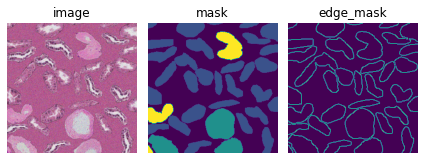

In [21]:
visualize_one_sample(dataset, 50, positive_only=True)

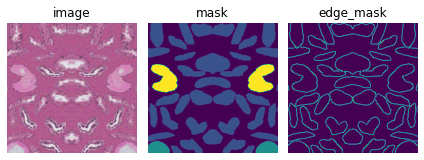

In [22]:
visualize_one_sample(dataset, 60, positive_only=False)

In [23]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

## Simulate the training procedure to test the functionality of dataloader

In [24]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [25]:
from training.unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [26]:
unet = UNet(in_channels=3,
            n_classes=5,
            depth = 8,# this depth may need to be modified
            wf = 3,
            padding = True,
            batch_norm = True,
            up_mode = "upconv"
            ).to(device)

optimizer = torch.optim.Adam(params = unet.parameters(),lr = 1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience = 25, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction="none")
EPOCH = 10

In [27]:
#tensorboard if necessary
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [28]:
logs_base_dir = Path("/tmp/tf-log")
logs_base_dir.mkdir(exist_ok=True)
tb = SummaryWriter(logs_base_dir)

In [29]:
for i, data in enumerate(dataloader):
    img, mask, edge_mask = list(map(lambda x: x.to(device), data))
    if i == 0:
        list(map(lambda x: print(f"Shape: {x.shape}, Dtype: {x.dtype}"), data))

    unet.zero_grad()
    # generate a naive prediction using binary random samples
    output = unet(img)

    loss_matrix = criterion(output, mask)
    loss = (loss_matrix * (edge_weight**edge_mask)).mean()

    loss.backward()
    optimizer.step()

    loss_val = loss.detach().cpu().item()
    tb.add_scalar("loss", loss_val, i)
    print(f"Batch {i} has loss: {loss_val}")

Shape: torch.Size([8, 3, 256, 256]), Dtype: torch.float32
Shape: torch.Size([8, 256, 256]), Dtype: torch.int64
Shape: torch.Size([8, 256, 256]), Dtype: torch.float32
Batch 0 has loss: 1.4745101839359803e+19
Batch 1 has loss: 1.5279659104017056e+19
Batch 2 has loss: 1.4547613058336817e+19
Batch 3 has loss: 1.4372300327334445e+19
Batch 4 has loss: 1.3942394579408912e+19
Batch 5 has loss: 1.326824771653573e+19
Batch 6 has loss: 1.3492221533648585e+19
Batch 7 has loss: 1.3079968444906996e+19
Batch 8 has loss: 1.2584834169663652e+19
Batch 9 has loss: 1.2399887517778706e+19
Batch 10 has loss: 1.2229027808868827e+19
Batch 11 has loss: 1.2153032863691833e+19
Batch 12 has loss: 1.1141208387742597e+19
Batch 13 has loss: 1.1875851479887643e+19
Batch 14 has loss: 1.1172493891599335e+19
Batch 15 has loss: 1.0814842550293103e+19
Batch 16 has loss: 1.1578978942341612e+19
Batch 17 has loss: 1.0927704120349426e+19
Batch 18 has loss: 9.73377303104979e+18
Batch 19 has loss: 1.0126436121119293e+19
Batch 2